<a href="https://colab.research.google.com/github/hungpham13/Face-mask-detection/blob/main/PRJ1_Face_Mask_Detection_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/hungpham13/Face-mask-detection.git

fatal: destination path 'Face-mask-detection' already exists and is not an empty directory.


## Import required libraries

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler, RandomSampler
from torch.utils.data import Subset

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install opencv-python-headless==4.1.2.30
import albumentations as A
from albumentations.augmentations.dropout import functional as AF
from albumentations.pytorch import ToTensorV2
import cv2

import time
from pprint import PrettyPrinter
from bs4 import BeautifulSoup
import os
from pathlib import Path
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models
from torchvision.utils import save_image
import torchvision.transforms.functional as F
from PIL import Image
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from google.colab import drive
drive.mount('/content/drive')

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-00k29pki
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-00k29pki
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Global variables
annotation_dir = "./Face-mask-detection/data/annotations/"
image_dir = "./Face-mask-detection/data/images/"

LABELS = ['without_mask', #0
          'mask_weared_incorrect', #1
          'with_mask' #2
          ] 

## Prepare data for Pytorch - Extract data from XML files

- img: transformed RGB image
- annotation: dictionary
    - boxes: tensor which each row is a box `[xmin, ymin, xmax, ymax]`
    - labels: tensor which each row is class corresponding to box
    - image_id: tensor with image number

In [ ]:
def clamp(x, min_val, max_val):
    '''Clamps input x into the range [min, max]'''
    return min(max(x,min_val),max_val)
def get_annotation(xml_file):
    with open(xml_file) as f:
        soup = BeautifulSoup(f.read(), 'xml')
        objects = soup.find_all('object')
        width = int(soup.find('width').text)
        height = int(soup.find('height').text)

        boxes,label_int = [],[]
        info = {}
        for obj in objects:
            label_int.append(LABELS.index(obj.find('name').text))
            xmin = int(obj.find('xmin').text)
            ymin = int(obj.find('ymin').text)
            xmax = int(obj.find('xmax').text)
            ymax = int(obj.find('ymax').text)
            # ensure box is not lie outside the image
            boxes.append([clamp(xmin,0,width), 
                          clamp(ymin,0,height),
                          clamp(xmax,0,width),
                          clamp(ymax,0,height)
                          ])
        # convert to tensor
        info['boxes'] = torch.as_tensor(boxes, dtype = torch.float32)
        info['labels'] = torch.as_tensor(label_int, dtype = torch.int64)+1
        return info

class MaskDataset(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        self.imgs = sorted([n for (d,_,n) in os.walk(image_dir)][0])
        self.to_tensor = transforms.Compose([transforms.ToTensor()])

    def __getitem__(self,idx):
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        img_path = os.path.join(image_dir, file_image)
        label_path = os.path.join(annotation_dir, file_label)
        img = Image.open(img_path).convert("RGB")

        #Get Label
        label = get_annotation(label_path)
        label['image_id'] = torch.tensor([idx])
        if self.transform:
            transformed = self.transform(image = np.array(img),
                                         bboxes = np.array(label['boxes']),
                                         class_labels = np.array(label['labels']))
            img = transformed['image']
            label['boxes'] = torch.as_tensor(transformed['bboxes'],dtype = torch.float32)
            label['labels'] = torch.as_tensor(transformed['class_labels'],dtype = torch.int64)
        return self.to_tensor(img), label

    def __len__(self):
        return len(self.imgs)

Check the class distribution in original dataset

[717, 123, 3232]

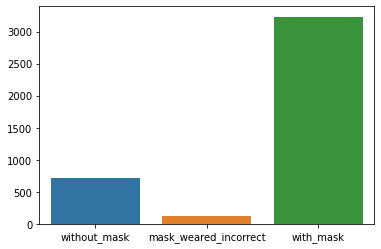

In [ ]:
def unzip_batch(batch):
    '''unzip the batch to individual pairs
    from (img1,img2,..),(label1,label2,...) to (img1,label1),(img2,label2),....
    '''
    return list(zip(*batch))

def plot_class_dist(data_loader,title=""):
    x = []
    for imgs, annotations in data_loader:
        x.extend([a['labels'] for a in annotations])
    instances_num = (torch.bincount(torch.cat(x)).tolist())[1:]
    sns.barplot(x=LABELS,y=instances_num).set_title(title)
    return instances_num

plot_class_dist(DataLoader(MaskDataset(), collate_fn = unzip_batch))

As you can see, number instances in each class are highly imbalance, we will perform some augmentation to tackle this problem

### Data augmentation

In [ ]:
# Source code from Albumentation library, I modified it to compatible with object detection problem
import random
from typing import Tuple, Iterable


class GridDropout(A.DualTransform):
    """GridDropout, drops out rectangular regions of an image and the corresponding mask in a grid fashion.
    Args:
        ratio (float): the ratio of the mask holes to the unit_size (same for horizontal and vertical directions).
            Must be between 0 and 1. Default: 0.5.
        unit_size_min (int): minimum size of the grid unit. Must be between 2 and the image shorter edge.
            If 'None', holes_number_x and holes_number_y are used to setup the grid. Default: `None`.
        unit_size_max (int): maximum size of the grid unit. Must be between 2 and the image shorter edge.
            If 'None', holes_number_x and holes_number_y are used to setup the grid. Default: `None`.
        holes_number_x (int): the number of grid units in x direction. Must be between 1 and image width//2.
            If 'None', grid unit width is set as image_width//10. Default: `None`.
        holes_number_y (int): the number of grid units in y direction. Must be between 1 and image height//2.
            If `None`, grid unit height is set equal to the grid unit width or image height, whatever is smaller.
        shift_x (int): offsets of the grid start in x direction from (0,0) coordinate.
            Clipped between 0 and grid unit_width - hole_width. Default: 0.
        shift_y (int): offsets of the grid start in y direction from (0,0) coordinate.
            Clipped between 0 and grid unit height - hole_height. Default: 0.
        random_offset (boolean): weather to offset the grid randomly between 0 and grid unit size - hole size
            If 'True', entered shift_x, shift_y are ignored and set randomly. Default: `False`.
        fill_value (int): value for the dropped pixels. Default = 0
        mask_fill_value (int): value for the dropped pixels in mask.
            If `None`, transformation is not applied to the mask. Default: `None`.
    Targets:
        image, mask
    Image types:
        uint8, float32
    References:
        https://arxiv.org/abs/2001.04086
    """

    def __init__(
        self,
        ratio: float = 0.5,
        unit_size_min: int = None,
        unit_size_max: int = None,
        holes_number_x: int = None,
        holes_number_y: int = None,
        shift_x: int = 0,
        shift_y: int = 0,
        random_offset: bool = False,
        fill_value: int = 0,
        mask_fill_value: int = None,
        always_apply: bool = False,
        p: float = 0.5,
    ):
        super(GridDropout, self).__init__(always_apply, p)
        self.ratio = ratio
        self.unit_size_min = unit_size_min
        self.unit_size_max = unit_size_max
        self.holes_number_x = holes_number_x
        self.holes_number_y = holes_number_y
        self.shift_x = shift_x
        self.shift_y = shift_y
        self.random_offset = random_offset
        self.fill_value = fill_value
        self.mask_fill_value = mask_fill_value
        if not 0 < self.ratio <= 1:
            raise ValueError("ratio must be between 0 and 1.")

    def apply(self, img: np.ndarray, holes: Iterable[Tuple[int, int, int, int]] = (), **params) -> np.ndarray:
        return AF.cutout(img, holes, self.fill_value)

    def apply_to_bbox(self, bbox, **params):
        return bbox

    def get_params_dependent_on_targets(self, params):
        img = params["image"]
        height, width = img.shape[:2]
        # set grid using unit size limits
        if self.unit_size_min and self.unit_size_max:
            if not 2 <= self.unit_size_min <= self.unit_size_max:
                raise ValueError("Max unit size should be >= min size, both at least 2 pixels.")
            if self.unit_size_max > min(height, width):
                raise ValueError("Grid size limits must be within the shortest image edge.")
            unit_width = random.randint(self.unit_size_min, self.unit_size_max + 1)
            unit_height = unit_width
        else:
            # set grid using holes numbers
            if self.holes_number_x is None:
                unit_width = max(2, width // 10)
            else:
                if not 1 <= self.holes_number_x <= width // 2:
                    raise ValueError("The hole_number_x must be between 1 and image width//2.")
                unit_width = width // self.holes_number_x
            if self.holes_number_y is None:
                unit_height = max(min(unit_width, height), 2)
            else:
                if not 1 <= self.holes_number_y <= height // 2:
                    raise ValueError("The hole_number_y must be between 1 and image height//2.")
                unit_height = height // self.holes_number_y

        hole_width = int(unit_width * self.ratio)
        hole_height = int(unit_height * self.ratio)
        # min 1 pixel and max unit length - 1
        hole_width = min(max(hole_width, 1), unit_width - 1)
        hole_height = min(max(hole_height, 1), unit_height - 1)
        # set offset of the grid
        if self.shift_x is None:
            shift_x = 0
        else:
            shift_x = min(max(0, self.shift_x), unit_width - hole_width)
        if self.shift_y is None:
            shift_y = 0
        else:
            shift_y = min(max(0, self.shift_y), unit_height - hole_height)
        if self.random_offset:
            shift_x = random.randint(0, unit_width - hole_width)
            shift_y = random.randint(0, unit_height - hole_height)
        holes = []
        for i in range(width // unit_width + 1):
            for j in range(height // unit_height + 1):
                x1 = min(shift_x + unit_width * i, width)
                y1 = min(shift_y + unit_height * j, height)
                x2 = min(x1 + hole_width, width)
                y2 = min(y1 + hole_height, height)
                holes.append((x1, y1, x2, y2))

        return {"holes": holes}

    @property
    def targets_as_params(self):
        return ["image"]

    def get_transform_init_args_names(self):
        return (
            "ratio",
            "unit_size_min",
            "unit_size_max",
            "holes_number_x",
            "holes_number_y",
            "shift_x",
            "shift_y",
            "mask_fill_value",
            "random_offset",
        )

- Create the dataset
- Split the dataset to 20% validation and 80% training set


In [ ]:
#weighted function for sampling, image with low class of 0 and 1 has higher weight
def get_weight(labels):
    num = torch.bincount(labels,minlength=4)[1:]
    freq = num/num.sum()
    return 0.7*freq[1]+0.29*freq[0]+0.01*freq[2]

get_weight(torch.tensor([1,1,1,1]))

tensor(0.2900)

In [ ]:
train_transform = A.Compose([
                    #    A.RandomCrop(width=450, height=450), 
                       A.HorizontalFlip(p=0.5),  
                       A.Rotate(limit=25, p=0.5), 
                       A.Perspective(scale=(0.05, 0.1), fit_output=True, p=0.5),
                    #    A.GaussianBlur(blur_limit=(3, 7), p=0.5),
                       A.RandomBrightnessContrast(p=0.5),
                       GridDropout(ratio=0.2,p=0.1),
], bbox_params=A.BboxParams(format='pascal_voc',min_visibility=0.3, label_fields=['class_labels']))


batch_size = 4
validation_split = .2
num_workers = 2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(MaskDataset())
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_dataset = Subset(MaskDataset(train_transform),train_indices)
val_dataset = Subset(MaskDataset(),val_indices)

# Creating PT data samplers and loaders:
weights = torch.cat([get_weight(a['labels']).unsqueeze(0) for i,a in train_dataset])
train_sampler = WeightedRandomSampler(weights, len(weights))
val_sampler = RandomSampler(val_dataset)

train_loader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size, num_workers=num_workers, collate_fn=unzip_batch)
test_loader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size, num_workers=num_workers, collate_fn=unzip_batch)

By applying different augmentation techiniques, we achive richer training dataset. Note that this apply to only training set, not validation set

[1273, 376, 1494]

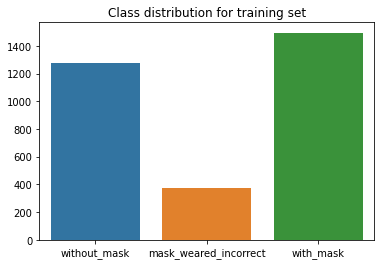

In [ ]:
plot_class_dist(train_loader,title="Class distribution for training set")

[171, 23, 677]

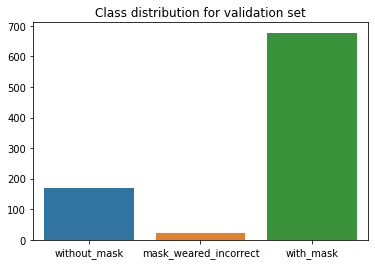

In [ ]:
plot_class_dist(test_loader,title="Class distribution for validation set")

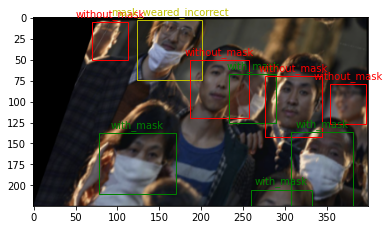

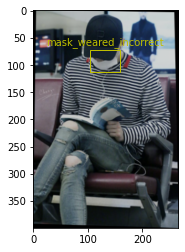

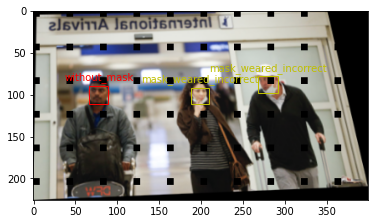

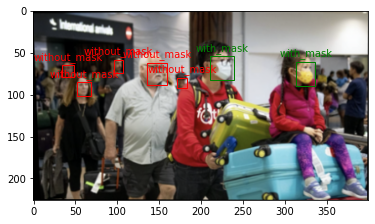

In [ ]:
def plot_image(img_tensor, annotation):
    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data
    # int to label and color
    COLORS = ['r','y','g']

    # Display the image
    ax.imshow(img.permute(1, 2, 0))

    for i,box in enumerate(annotation['boxes']):
        xmin, ymin, xmax, ymax = box

        # Create a Rectangle patch
        index = int(annotation['labels'][i])-1
        label, color = LABELS[index], COLORS[index]
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor=color,facecolor='none')
        ax.annotate(label,color=color,
                    xy = (xmin+(xmax-xmin)/2,ymin), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 8), 
                    textcoords = 'offset points')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()


img_batch, label_batch = next(iter(train_loader))

for img,label in zip(img_batch,label_batch):
    # print(img)
    # print(f"Feature batch shape: {img.size()}")
    # print(f"Labels batch : {label}")
    plot_image(img, label)

# Evaluation function

In [ ]:
def find_jaccard_overlap(set_1, set_2):
    """
    Find the Jaccard Overlap (IoU) of every box combination between two sets of boxes that are in boundary coordinates.
    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: Jaccard Overlap of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """
    # Find intersections
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  # (n1, n2, 2)
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))  # (n1, n2, 2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  # (n1, n2, 2)
    intersection = intersection_dims[:, :, 0] * intersection_dims[:, :, 1]  # (n1, n2)
    # Find areas of each box in both sets
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])  # (n1)
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])  # (n2)
    # Find the union
    # PyTorch auto-broadcasts singleton dimensions
    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection  # (n1, n2)
    return intersection / union  # (n1, n2)


In [ ]:
def calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels, n_classes =4, iou_thres=0.5):

    """
    Calculate the Mean Average Precision (mAP) of detected objects.
    See https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173 for an explanation
    :param det_boxes: list of tensors, one tensor for each image containing detected objects' bounding boxes
    :param det_labels: list of tensors, one tensor for each image containing detected objects' labels
    :param det_scores: list of tensors, one tensor for each image containing detected objects' labels' scores
    :param true_boxes: list of tensors, one tensor for each image containing actual objects' bounding boxes
    :param true_labels: list of tensors, one tensor for each image containing actual objects' labels
    :param true_difficulties: list of tensors, one tensor for each image containing actual objects' difficulty (0 or 1)
    :return: list of average precisions for all classes, mean average precision (mAP)
    """
    true_difficulties = [torch.zeros(len(b)) for b in true_boxes]
    assert len(det_boxes) == len(det_labels) == len(det_scores) == len(true_boxes) == len(
        true_labels) == len(
        true_difficulties)  # these are all lists of tensors of the same length, i.e. number of images

    # Store all (true) objects in a single continuous tensor while keeping track of the image it is from
    true_images = list()
    for i in range(len(true_labels)):
        true_images.extend([i] * true_labels[i].size(0))
    true_images = torch.LongTensor(true_images).to(
        device)  # (n_objects), n_objects is the total no. of objects across all images
    true_boxes = torch.cat(true_boxes, dim=0)  # (n_objects, 4)
    true_labels = torch.cat(true_labels, dim=0)  # (n_objects)
    true_difficulties = torch.cat(true_difficulties, dim=0)  # (n_objects)

    assert true_images.size(0) == true_boxes.size(0) == true_labels.size(0)

    # Store all detections in a single continuous tensor while keeping track of the image it is from
    det_images = list()
    for i in range(len(det_labels)):
        det_images.extend([i] * det_labels[i].size(0))
    det_images = torch.LongTensor(det_images).to(device)  # (n_detections)
    det_boxes = torch.cat(det_boxes, dim=0)  # (n_detections, 4)
    det_labels = torch.cat(det_labels, dim=0)  # (n_detections)
    det_scores = torch.cat(det_scores, dim=0)  # (n_detections)

    assert det_images.size(0) == det_boxes.size(0) == det_labels.size(0) == det_scores.size(0)

    # Calculate APs for each class (except background)
    average_precisions = torch.zeros((n_classes - 1), dtype=torch.float)  # (n_classes - 1)
    for c in range(1, n_classes):
        # Extract only objects with this class
        true_class_images = true_images[true_labels == c]  # (n_class_objects)
        true_class_boxes = true_boxes[true_labels == c]  # (n_class_objects, 4)
        true_class_difficulties = true_difficulties[true_labels == c]  # (n_class_objects)
        n_easy_class_objects = (1 - true_class_difficulties).sum().item()  # ignore difficult objects

        # Keep track of which true objects with this class have already been 'detected'
        # So far, none
        true_class_boxes_detected = torch.zeros((true_class_difficulties.size(0)), dtype=torch.uint8).to(
            device)  # (n_class_objects)

        # Extract only detections with this class
        det_class_images = det_images[det_labels == c]  # (n_class_detections)
        det_class_boxes = det_boxes[det_labels == c]  # (n_class_detections, 4)
        det_class_scores = det_scores[det_labels == c]  # (n_class_detections)
        n_class_detections = det_class_boxes.size(0)
        if n_class_detections == 0:
            continue

        # Sort detections in decreasing order of confidence/scores
        det_class_scores, sort_ind = torch.sort(det_class_scores, dim=0, descending=True)  # (n_class_detections)
        det_class_images = det_class_images[sort_ind]  # (n_class_detections)
        det_class_boxes = det_class_boxes[sort_ind]  # (n_class_detections, 4)

        # In the order of decreasing scores, check if true or false positive
        true_positives = torch.zeros((n_class_detections), dtype=torch.float).to(device)  # (n_class_detections)
        false_positives = torch.zeros((n_class_detections), dtype=torch.float).to(device)  # (n_class_detections)
        for d in range(n_class_detections):
            this_detection_box = det_class_boxes[d].unsqueeze(0)  # (1, 4)
            this_image = det_class_images[d]  # (), scalar

            # Find objects in the same image with this class, their difficulties, and whether they have been detected before
            object_boxes = true_class_boxes[true_class_images == this_image]  # (n_class_objects_in_img)
            object_difficulties = true_class_difficulties[true_class_images == this_image]  # (n_class_objects_in_img)
            # If no such object in this image, then the detection is a false positive
            if object_boxes.size(0) == 0:
                false_positives[d] = 1
                continue

            # Find maximum overlap of this detection with objects in this image of this class
            overlaps = find_jaccard_overlap(this_detection_box, object_boxes)  # (1, n_class_objects_in_img)
            max_overlap, ind = torch.max(overlaps.squeeze(0), dim=0)  # (), () - scalars

            # 'ind' is the index of the object in these image-level tensors 'object_boxes', 'object_difficulties'
            # In the original class-level tensors 'true_class_boxes', etc., 'ind' corresponds to object with index...
            original_ind = torch.LongTensor(range(true_class_boxes.size(0)))[true_class_images == this_image][ind]
            # We need 'original_ind' to update 'true_class_boxes_detected'

            # If the maximum overlap is greater than the threshold of 0.5, it's a match
            if max_overlap.item() > iou_thres:
                # If the object it matched with is 'difficult', ignore it
                if object_difficulties[ind] == 0:
                    # If this object has already not been detected, it's a true positive
                    if true_class_boxes_detected[original_ind] == 0:
                        true_positives[d] = 1
                        true_class_boxes_detected[original_ind] = 1  # this object has now been detected/accounted for
                    # Otherwise, it's a false positive (since this object is already accounted for)
                    else:
                        false_positives[d] = 1
            # Otherwise, the detection occurs in a different location than the actual object, and is a false positive
            else:
                false_positives[d] = 1

        # Compute cumulative precision and recall at each detection in the order of decreasing scores
        cumul_true_positives = torch.cumsum(true_positives, dim=0)  # (n_class_detections)
        cumul_false_positives = torch.cumsum(false_positives, dim=0)  # (n_class_detections)
        cumul_precision = cumul_true_positives / (
                cumul_true_positives + cumul_false_positives + 1e-10)  # (n_class_detections)
        cumul_recall = cumul_true_positives / n_easy_class_objects  # (n_class_detections)

        # Find the mean of the maximum of the precisions corresponding to recalls above the threshold 't'
        recall_thresholds = torch.arange(start=0, end=1.1, step=.1).tolist()  # (11)
        precisions = torch.zeros((len(recall_thresholds)), dtype=torch.float).to(device)  # (11)
        for i, t in enumerate(recall_thresholds):
            recalls_above_t = cumul_recall >= t
            if recalls_above_t.any():
                precisions[i] = cumul_precision[recalls_above_t].max()
            else:
                precisions[i] = 0.
        average_precisions[c - 1] = precisions.mean()  # c is in [1, n_classes - 1]

    # Calculate Mean Average Precision (mAP)
    mean_average_precision = average_precisions.mean().item()

    return average_precisions, mean_average_precision

In [ ]:
class Evaluator(object):
    def __init__(self):
        self.det_boxes = []
        self.det_labels = []
        self.det_scores = []
        self.true_boxes = []
        self.true_labels = []
    def update(self, targets, outputs):
        """extend a set of targets and outputs to evaluation data"""
        for output in outputs:
            self.det_boxes.append(output['boxes'])
            self.det_labels.append(output['labels'])
            self.det_scores.append(output['scores'])
        for target in targets:
            self.true_boxes.append(target['boxes'])
            self.true_labels.append(target['labels'])
    def summarize(self):
        APs, mAP = calculate_mAP(self.det_boxes, self.det_labels, self.det_scores, self.true_boxes, self.true_labels)
        mAP_l = []
        for thres in np.arange(0.5,1,0.05):
            APs_l, AP_l = calculate_mAP(self.det_boxes, self.det_labels, self.det_scores, 
                          self.true_boxes, self.true_labels,iou_thres=thres)
            mAP_l.append([APs_l.tolist(),AP_l])
        mAP_l = np.array(mAP_l)
        
        # Print AP for each class
        pp = PrettyPrinter()
        print('Mean Average Precision of each class')
        pp.pprint({LABELS[c]: v for c, v in enumerate(APs.tolist())})
        # Good formatting when printing the APs for each class and mAP
        print('\nMean Average Precision (mAP): %.3f' % mAP)
        return {"mAP_each_class":APs.tolist(), 
                  "mAP_0.5":mAP, 
                  'mAP_0.5:0.95':np.mean(mAP_l[:,1]), 
                  'mAP_0.5:0.95_each':[np.mean([t[i] for t in mAP_l[:,0]]) for i in range(len(LABELS))]
                }


In [ ]:
class Tracker(object):
    def __init__(self,epoch_num):
        self.data=pd.DataFrame(columns=['epoch','training loss','mAP_0.5',
                                        'mAP_each_class',
                                        'mAP_0.5:0.95','mAP_0.5:0.95_each'])
        self.data['epoch'] = range(epoch_num)
    def update_evaluation(self,val, epoch):
        for k in val:
            self.data[k].loc[epoch] = val[k]
    def update_loss(self, loss, epoch):
        self.data['training loss'].loc[epoch] = loss
    def plot_result(self):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15,6))
        sns.lineplot(data=self.data, x='epoch', y='training loss',markers=True,ax=ax1)

        sns.lineplot(data=self.data, x='epoch', y='mAP_0.5',markers=True,ax=ax2)
        sns.lineplot(data=self.data, x='epoch', y='mAP_0.5:0.95',markers=True,ax=ax3)
        plt.show()
    def plot_result_each(self):
        fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,6))
        data1 = pd.DataFrame([eval(i) for i in self.data['mAP_each_class']],columns=LABELS,)
        data2 = pd.DataFrame([eval(i) for i in self.data['mAP_0.5:0.95_each']],columns=LABELS)
        sns.lineplot(data=data1,ax=ax1)
        ax1.set_xlabel('epoch')
        ax1.set(xlabel='epoch', ylabel='mAP_0.5')
        ax2.set(xlabel='epoch', ylabel='mAP_0.5:0.95')

        sns.lineplot(data=data2,ax=ax2)
        plt.show()

    def save_result(self):
        self.data.to_csv("/content/drive/My Drive/result.csv")
    def load_result(self):
        self.data = pd.read_csv("/content/drive/My Drive/result.csv")

# Build model
- Faster RCNN
- YOLO

In [ ]:
# Helper function
PATH = f'/content/drive/MyDrive/cp1'

def save_model(epoch, model, optimizer):
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, PATH)


### Approach 1: Faster R-CNN

> The models expect a list of `Tensor[C, H, W]`, in the range `0-1`. The models internally resize the images but the behaviour varies depending on the model. Check the constructor of the models for more information. The output format of such models is illustrated in Instance segmentation models

...

>Here are the summary of the accuracies for the models trained on the instances set of COCO train2017 and evaluated on COCO val2017.

<table class="docutils align-default">
<colgroup>
<col style="width: 59%">
<col style="width: 11%">
<col style="width: 13%">
<col style="width: 17%">
</colgroup>
<thead>
<tr class="row-odd"><th class="head"><p>Network</p></th>
<th class="head"><p>box AP</p></th>
<th class="head"><p>mask AP</p></th>
<th class="head"><p>keypoint AP</p></th>
</tr>
</thead>
<tbody>
<tr class="row-even"><td><p>Faster R-CNN ResNet-50 FPN</p></td>
<td><p>37.0</p></td>
<td><ul class="simple">
<li></li>
</ul>
</td>
<td><ul class="simple">
<li></li>
</ul>
</td>
</tr>
<tr class="row-odd"><td><p>Faster R-CNN MobileNetV3-Large FPN</p></td>
<td><p>32.8</p></td>
<td><ul class="simple">
<li></li>
</ul>
</td>
<td><ul class="simple">
<li></li>
</ul>
</td>
</tr>
<tr class="row-even"><td><p>Faster R-CNN MobileNetV3-Large 320 FPN</p></td>
<td><p>22.8</p></td>
<td><ul class="simple">
<li></li>
</ul>
</td>
<td><ul class="simple">
<li></li>
</ul>
</td>
</tr>
<tr class="row-odd"><td><p>RetinaNet ResNet-50 FPN</p></td>
<td><p>36.4</p></td>
<td><ul class="simple">
<li></li>
</ul>
</td>
<td><ul class="simple">
<li></li>
</ul>
</td>
</tr>
<tr class="row-even"><td><p>SSD300 VGG16</p></td>
<td><p>25.1</p></td>
<td><ul class="simple">
<li></li>
</ul>
</td>
<td><ul class="simple">
<li></li>
</ul>
</td>
</tr>
<tr class="row-odd"><td><p>SSDlite320 MobileNetV3-Large</p></td>
<td><p>21.3</p></td>
<td><ul class="simple">
<li></li>
</ul>
</td>
<td><ul class="simple">
<li></li>
</ul>
</td>
</tr>
<tr class="row-even"><td><p>Mask R-CNN ResNet-50 FPN</p></td>
<td><p>37.9</p></td>
<td><p>34.6</p></td>
<td><ul class="simple">
<li></li>
</ul>
</td>
</tr>
</tbody>
</table>

In [ ]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
# model = get_model_instance_segmentation(4)
# images,targets = next(iter(train_loader))
# images = list(image for image in images)
# targets = [{k: v for k, v in t.items()} for t in targets]
# output = model(images,targets) # Returns losses and detections
# # For inference
# model.eval()
# x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
# predictions = model(x)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

# get the model using our helper function
model = get_model_instance_segmentation(4)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)


cuda


In [ ]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, tracker):
    print("Start training epoch",epoch)
    model.train()
    epoch_loss = 0
    training_time = time.time()
    for i, (imgs, annotations) in enumerate(tqdm(data_loader)):
        # change device
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        #calc the loss
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        #reset gradient
        optimizer.zero_grad()
        #calc gradient
        losses.backward()
        #update weight
        optimizer.step()
        epoch_loss += losses
    training_time = time.time() - training_time
    print(f"Epoch {epoch} - Training loss: {epoch_loss/len(data_loader)}")
    tracker.update_loss(epoch_loss.cpu().item()/len(data_loader),epoch)
    print(f"Epoch {epoch} - Training time: {training_time}")

def evaluate(model, data_loader, device, tracker, epoch):
    valid_loss = 0
    cpu_device = torch.device("cpu")
    evaluator = Evaluator()
    model.eval()
    with torch.no_grad():
        for imgs, targets in data_loader:
            # change device
            imgs = list(img.to(device) for img in imgs)

            outputs = model(imgs)
            outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
            evaluator.update(targets,outputs)
            # print(f"Evaluation time: {model_time}")
            # print(outputs)
            # res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
            # print(res)
        tracker.update_evaluation(evaluator.summarize(),epoch)

In [ ]:
def train(cont=False):
    num_epochs = 25
    epoch = 0
    tracker = Tracker(num_epochs)
    while epoch < num_epochs:
        if cont:
            checkpoint = torch.load(PATH)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            epoch = checkpoint['epoch']
            tracker.load_result()
            print("Continue at epoch",epoch)
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, train_loader, device, epoch, tracker)
        # evaluate on the test dataset
        evaluate(model, test_loader, device, tracker, epoch)
        #update parameter
        epoch +=1
        cont=False
        #save the model
        save_model(epoch,model,optimizer)
        tracker.save_result()

In [ ]:
train()
# train(cont=True)

Start training epoch 0


  0%|          | 0/171 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 171/171 [04:55<00:00,  1.73s/it]


Epoch 0 - Training loss: 0.5137126445770264
Epoch 0 - Training time: 295.45349049568176


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Mean Average Precision of each class
{'mask_weared_incorrect': 0.07853955030441284,
 'with_mask': 0.8730448484420776,
 'without_mask': 0.7924497723579407}

Mean Average Precision (mAP): 0.581
Start training epoch 1


100%|██████████| 171/171 [05:02<00:00,  1.77s/it]


Epoch 1 - Training loss: 0.350597620010376
Epoch 1 - Training time: 302.676212310791
Mean Average Precision of each class
{'mask_weared_incorrect': 0.20758742094039917,
 'with_mask': 0.8861174583435059,
 'without_mask': 0.8386136293411255}

Mean Average Precision (mAP): 0.644
Start training epoch 2


100%|██████████| 171/171 [05:16<00:00,  1.85s/it]


Epoch 2 - Training loss: 0.29276469349861145
Epoch 2 - Training time: 316.3095393180847
Mean Average Precision of each class
{'mask_weared_incorrect': 0.4732501804828644,
 'with_mask': 0.8956321477890015,
 'without_mask': 0.8419427871704102}

Mean Average Precision (mAP): 0.737
Start training epoch 3


100%|██████████| 171/171 [05:04<00:00,  1.78s/it]


Epoch 3 - Training loss: 0.28066059947013855
Epoch 3 - Training time: 304.8500452041626
Mean Average Precision of each class
{'mask_weared_incorrect': 0.5742870569229126,
 'with_mask': 0.8954959511756897,
 'without_mask': 0.8558371663093567}

Mean Average Precision (mAP): 0.775
Start training epoch 4


100%|██████████| 171/171 [05:03<00:00,  1.78s/it]


Epoch 4 - Training loss: 0.24809089303016663
Epoch 4 - Training time: 303.81140089035034
Mean Average Precision of each class
{'mask_weared_incorrect': 0.5242717862129211,
 'with_mask': 0.8845828175544739,
 'without_mask': 0.8499395251274109}

Mean Average Precision (mAP): 0.753
Start training epoch 5


100%|██████████| 171/171 [05:07<00:00,  1.80s/it]


Epoch 5 - Training loss: 0.2713809013366699
Epoch 5 - Training time: 307.89525055885315
Mean Average Precision of each class
{'mask_weared_incorrect': 0.5599496960639954,
 'with_mask': 0.8985181450843811,
 'without_mask': 0.8617003560066223}

Mean Average Precision (mAP): 0.773
Start training epoch 6


100%|██████████| 171/171 [05:10<00:00,  1.82s/it]


Epoch 6 - Training loss: 0.24279731512069702
Epoch 6 - Training time: 310.7001678943634
Mean Average Precision of each class
{'mask_weared_incorrect': 0.5779585838317871,
 'with_mask': 0.9011903405189514,
 'without_mask': 0.8584195375442505}

Mean Average Precision (mAP): 0.779
Start training epoch 7


100%|██████████| 171/171 [05:09<00:00,  1.81s/it]


Epoch 7 - Training loss: 0.23886901140213013
Epoch 7 - Training time: 309.28747296333313
Mean Average Precision of each class
{'mask_weared_incorrect': 0.5664559006690979,
 'with_mask': 0.8979611992835999,
 'without_mask': 0.8551562428474426}

Mean Average Precision (mAP): 0.773
Start training epoch 8


100%|██████████| 171/171 [05:11<00:00,  1.82s/it]


Epoch 8 - Training loss: 0.22177563607692719
Epoch 8 - Training time: 311.0453927516937
Mean Average Precision of each class
{'mask_weared_incorrect': 0.5799534916877747,
 'with_mask': 0.8998612761497498,
 'without_mask': 0.8627696633338928}

Mean Average Precision (mAP): 0.781
Start training epoch 9


100%|██████████| 171/171 [05:08<00:00,  1.80s/it]


Epoch 9 - Training loss: 0.21715106070041656
Epoch 9 - Training time: 308.23277974128723
Mean Average Precision of each class
{'mask_weared_incorrect': 0.6027942895889282,
 'with_mask': 0.8953956365585327,
 'without_mask': 0.8514174818992615}

Mean Average Precision (mAP): 0.783
Start training epoch 10


100%|██████████| 171/171 [05:07<00:00,  1.80s/it]


Epoch 10 - Training loss: 0.20313923060894012
Epoch 10 - Training time: 307.4007589817047
Mean Average Precision of each class
{'mask_weared_incorrect': 0.6035033464431763,
 'with_mask': 0.9001026153564453,
 'without_mask': 0.864692211151123}

Mean Average Precision (mAP): 0.789
Start training epoch 11


100%|██████████| 171/171 [05:05<00:00,  1.78s/it]


Epoch 11 - Training loss: 0.19781643152236938
Epoch 11 - Training time: 305.1039390563965
Mean Average Precision of each class
{'mask_weared_incorrect': 0.5449572205543518,
 'with_mask': 0.8903095126152039,
 'without_mask': 0.8688524961471558}

Mean Average Precision (mAP): 0.768
Start training epoch 12


100%|██████████| 171/171 [05:05<00:00,  1.79s/it]


Epoch 12 - Training loss: 0.20367616415023804
Epoch 12 - Training time: 305.64761877059937
Mean Average Precision of each class
{'mask_weared_incorrect': 0.5616161823272705,
 'with_mask': 0.8997617363929749,
 'without_mask': 0.8616014122962952}

Mean Average Precision (mAP): 0.774
Start training epoch 13


100%|██████████| 171/171 [05:05<00:00,  1.79s/it]


Epoch 13 - Training loss: 0.20381881296634674
Epoch 13 - Training time: 305.5906720161438
Mean Average Precision of each class
{'mask_weared_incorrect': 0.6030719876289368,
 'with_mask': 0.9000088572502136,
 'without_mask': 0.8613358736038208}

Mean Average Precision (mAP): 0.788
Start training epoch 14


100%|██████████| 171/171 [05:10<00:00,  1.82s/it]


Epoch 14 - Training loss: 0.21154776215553284
Epoch 14 - Training time: 310.52570247650146
Mean Average Precision of each class
{'mask_weared_incorrect': 0.681736409664154,
 'with_mask': 0.9008617401123047,
 'without_mask': 0.8666689991950989}

Mean Average Precision (mAP): 0.816
Start training epoch 15


100%|██████████| 171/171 [05:07<00:00,  1.80s/it]


Epoch 15 - Training loss: 0.1840217411518097
Epoch 15 - Training time: 307.79168677330017
Mean Average Precision of each class
{'mask_weared_incorrect': 0.6111575365066528,
 'with_mask': 0.9003161191940308,
 'without_mask': 0.856606662273407}

Mean Average Precision (mAP): 0.789
Start training epoch 16


100%|██████████| 171/171 [05:03<00:00,  1.77s/it]


Epoch 16 - Training loss: 0.1908021867275238
Epoch 16 - Training time: 303.4323980808258
Mean Average Precision of each class
{'mask_weared_incorrect': 0.6401694416999817,
 'with_mask': 0.9015881419181824,
 'without_mask': 0.867233157157898}

Mean Average Precision (mAP): 0.803
Start training epoch 17


100%|██████████| 171/171 [05:05<00:00,  1.79s/it]


Epoch 17 - Training loss: 0.18949274718761444
Epoch 17 - Training time: 305.4156062602997
Mean Average Precision of each class
{'mask_weared_incorrect': 0.6111111640930176,
 'with_mask': 0.8987981677055359,
 'without_mask': 0.8267250061035156}

Mean Average Precision (mAP): 0.779
Start training epoch 18


100%|██████████| 171/171 [05:06<00:00,  1.79s/it]


Epoch 18 - Training loss: 0.18025396764278412
Epoch 18 - Training time: 306.13466811180115
Mean Average Precision of each class
{'mask_weared_incorrect': 0.6571580171585083,
 'with_mask': 0.8987756371498108,
 'without_mask': 0.8660315275192261}

Mean Average Precision (mAP): 0.807
Start training epoch 19


100%|██████████| 171/171 [05:07<00:00,  1.80s/it]


Epoch 19 - Training loss: 0.18910634517669678
Epoch 19 - Training time: 307.03100848197937
Mean Average Precision of each class
{'mask_weared_incorrect': 0.6448313593864441,
 'with_mask': 0.9008100032806396,
 'without_mask': 0.8667546510696411}

Mean Average Precision (mAP): 0.804
Start training epoch 20


100%|██████████| 171/171 [05:06<00:00,  1.80s/it]


Epoch 20 - Training loss: 0.15919120609760284
Epoch 20 - Training time: 306.99231362342834
Mean Average Precision of each class
{'mask_weared_incorrect': 0.5880231261253357,
 'with_mask': 0.9012988209724426,
 'without_mask': 0.8561117053031921}

Mean Average Precision (mAP): 0.782
Start training epoch 21


100%|██████████| 171/171 [05:05<00:00,  1.79s/it]


Epoch 21 - Training loss: 0.17602898180484772
Epoch 21 - Training time: 305.80996441841125
Mean Average Precision of each class
{'mask_weared_incorrect': 0.6574373245239258,
 'with_mask': 0.8967793583869934,
 'without_mask': 0.8682771325111389}

Mean Average Precision (mAP): 0.807
Start training epoch 22


100%|██████████| 171/171 [05:09<00:00,  1.81s/it]


Epoch 22 - Training loss: 0.1713610291481018
Epoch 22 - Training time: 309.153945684433
Mean Average Precision of each class
{'mask_weared_incorrect': 0.5921066403388977,
 'with_mask': 0.9005879759788513,
 'without_mask': 0.8639365434646606}

Mean Average Precision (mAP): 0.786
Start training epoch 23


100%|██████████| 171/171 [05:16<00:00,  1.85s/it]


Epoch 23 - Training loss: 0.17020778357982635
Epoch 23 - Training time: 316.85434007644653
Mean Average Precision of each class
{'mask_weared_incorrect': 0.5963128209114075,
 'with_mask': 0.9013602137565613,
 'without_mask': 0.874422550201416}

Mean Average Precision (mAP): 0.791
Start training epoch 24


 91%|█████████ | 156/171 [04:35<00:26,  1.74s/it]

In [ ]:
# save model
torch.save(model.state_dict(),'best_rcnn.pt')

In [ ]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

FPS: 6.3601929907231165


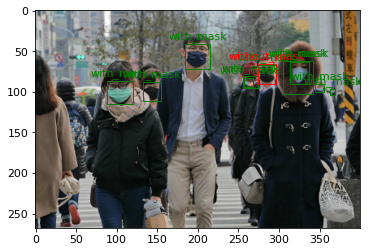

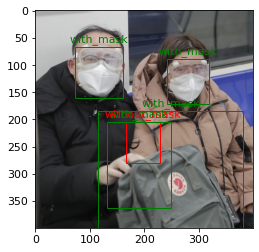

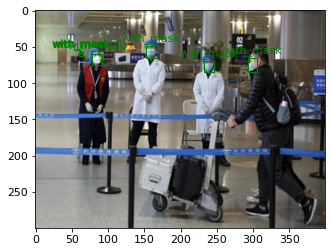

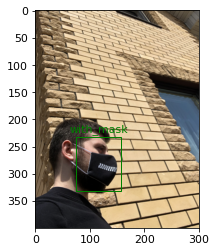

In [ ]:
with torch.no_grad():
    imgs, labels = next(iter(test_loader))
    imgs = list(img.to(device) for img in imgs)

    model_time = time.time()
    outputs = model(imgs)
    model_time = time.time() - model_time
    print(f"FPS: {4/model_time}")
    outputs = [{k: v.to(torch.device("cpu")) for k, v in t.items()} for t in outputs]

    for img,label in zip(imgs,outputs):
        # print(img)
        # print(f"Feature batch shape: {img.size()}")
        # print(f"Labels batch : {label}")
        plot_image(img, label)

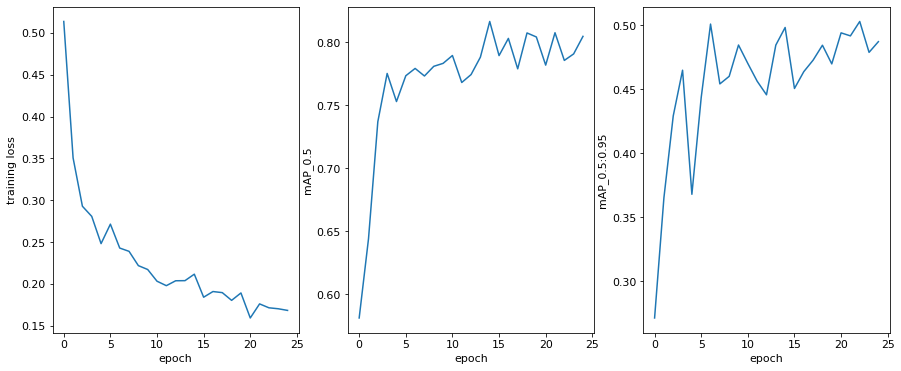

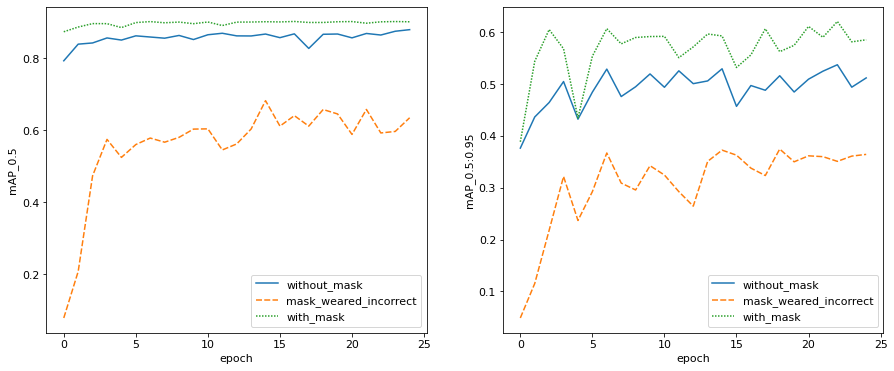

In [ ]:
a = Tracker(25)
a.load_result()
a.plot_result()
a.plot_result_each()

In [ ]:
a.data.loc[21]

Unnamed: 0                                                          21
epoch                                                               21
training loss                                                 0.176029
mAP_0.5                                                       0.807498
mAP_each_class       [0.8682771325111389, 0.6574373245239258, 0.896...
mAP_0.5:0.95                                                   0.49162
mAP_0.5:0.95_each    [0.5247753318399191, 0.3598635349422693, 0.590...
Name: 21, dtype: object

## Approach 2: YOLO
Version: YOLO v5

Here's what we'll go over:

- Build a custom dataset in YOLO/darknet format
- Learn about YOLO model family history
- Fine-tune the largest YOLO v5 model
- Evaluate the model
- Look at some predictions and save the model

### Build the dataset
YOLO v5 requires the dataset to be in the *darknet format*. Here's an outline of what it looks like:

- One txt with labels file per image
- One row per object
- Each row contains: `class_index x_center y_center bbox_width bbox_height`
- Box coordinates must be normalized between 0 and 1

Let's create a helper function that builds a dataset in the correct format for us:

In [ ]:
def dataloader_to_darknet(data_loader, dataset_type, labels=LABELS):
    assert dataset_type in ('train','val')

    images_path = Path(yolo_img_dir + dataset_type)
    images_path.mkdir(parents=True, exist_ok=True)

    labels_path = Path(yolo_label_dir + dataset_type)
    labels_path.mkdir(parents=True, exist_ok=True)

    i = 0  #image index

    for imgs, annotations in data_loader:
        for img, annot in zip(imgs, annotations):
            #Save image to folder
            save_image(img,images_path / f"{i}.png")

            #Save annotation file
            with (labels_path / f"{i}.txt").open(mode="w") as label_file:
                #get the size of the image
                img_w, img_h = F.get_image_size(img)
                for box_num, box in enumerate(annot['boxes']):
                    # get box coordinate and convert it to yolo format
                    box_w, box_h = (box[2]-box[0])/img_w, (box[3]-box[1])/img_h
                    label_file.write(
                        f"{annot['labels'][box_num]} {box[0]/img_w + box_w/2} {box[1]/img_h + box_h/2} {box_w} {box_h}\n"
                    )
            i += 1

In [ ]:
yolo_label_dir = "./facemask/labels/"
yolo_img_dir="./facemask/images/"
dataloader_to_darknet(train_loader,'train')
dataloader_to_darknet(test_loader,'val')

### Fine-tuning YOLO v5

The YOLO abbreviation stands for You Only Look Once. YOLO models are one stage object detectors. 

YOLO models are very light and fast. They are [not the most accurate object detections around](https://paperswithcode.com/sota/object-detection-on-coco), though. Ultimately, those models are the choice of many (if not all) practitioners interested in [real-time object detection (FPS >30)](https://paperswithcode.com/sota/real-time-object-detection-on-coco).

### Contreversy

Joseph Redmon introduced YOLO v1 in the 2016 paper [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/pdf/1506.02640.pdf). The implementation uses the [Darknet Neural Networks library](https://pjreddie.com/darknet/).

He also co-authored the YOLO v2 paper in 2017  [YOLO9000: Better, Faster, Stronger](https://arxiv.org/pdf/1612.08242.pdf). A significant improvement over the first iteration with much better localization of objects.

The final iteration, from the original author, was published in the 2018 paper [YOLOv3: An Incremental Improvement](https://arxiv.org/pdf/1804.02767.pdf).

Then things got a bit wacky. Alexey Bochkovskiy published [YOLOv4: Optimal Speed and Accuracy of Object Detection](https://arxiv.org/abs/2004.10934) on April 23, 2020. The project has [an open-source repository on GitHub](https://github.com/AlexeyAB/darknet).

YOLO v5 got open-sourced on [May 30, 2020](https://github.com/ultralytics/yolov5/commit/1e84a23f38fad9e52b59101e9f1246d93066ed1e) by [Glenn Jocher](https://github.com/glenn-jocher) from ultralytics. There is no published paper, but [the complete project is on GitHub](https://github.com/ultralytics/yolov5).

The community at Hacker News got into a [heated debate about the project naming](https://news.ycombinator.com/item?id=23478151). Even the guys at Roboflow wrote [Responding to the Controversy about YOLOv5](https://blog.roboflow.ai/yolov4-versus-yolov5/) article about it. They also did a great comparison between YOLO v4 and v5.


### YOLO v5 project setup

YOLO v5 uses PyTorch, but everything is abstracted away. You need the project itself (along with the required dependencies).

Let's start by cloning the GitHub repo and checking out a specific commit (to ensure reproducibility):

Let's start by installing some required libraries by the YOLOv5 project:

In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5 
%pip install -qr requirements.txt  # install
from yolov5 import utils
display = utils.notebook_init()  # checks

We'll also install [Apex by NVIDIA](https://nvidia.github.io/apex/) to speed up the training of our model:

In [ ]:
# !git clone https://github.com/NVIDIA/apex && cd apex && pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" . --user && cd .. && rm -rf apex

Create data yaml file

In [ ]:
with open("data/facemask.yaml","w") as f:
    f.write(f"\
train: .{yolo_img_dir}train\n\
val: .{yolo_img_dir}val\n\
\n\
nc: 3\n\
names: {LABELS}\
")

Config the model yaml file: 
- change the number of classes to 3

In [ ]:
#read the file
with open("models/yolov5x.yaml","r") as f:
    data = f.readlines()
#edit line 4: change number of class to 3
data[3] = 'nc: 3 # number of classes\n'
print(data)

#write back the file
with open("models/yolov5x.yaml","w") as f:
    f.writelines(data)

### Training

Fine-tuning an existing model is very easy. We'll use the largest model **YOLOv5x** (89M parameters), which is also the most accurate.

In our case, we don't really care about speed. We just want the best accuracy you can get. The checkpoint you're going to use for a different problem(s) is contextually specific. [Take a look at the overview of the pre-trained checkpoints](https://github.com/ultralytics/yolov5/blob/f9ae460eeccd30bdc43a89a37f74b9cc7b93d52f/README.md#pretrained-checkpoints).

To train a model on a custom dataset, we'll call the `train.py` script. We'll pass a couple of parameters:

- img_size: 640
- batch: 4
- epochs: 30
- data ./data/facemask.yaml - path to dataset config
- cfg ./models/yolov5x.yaml - model config
- weights yolov5x.pt - use pre-trained weights from the YOLOv5x model
- name yolov5x_facemask - name of our model
- cache - cache dataset images for faster training

In [ ]:
!python train.py --img 640 --batch 4 --epochs 30 \
  --data ./data/facemask.yaml --cfg ./models/yolov5x.yaml --weights yolov5x.pt \
  --name yolov5x_facemask --cache

train: weights=yolov5x.pt, cfg=./models/yolov5x.yaml, data=./data/facemask.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=30, batch_size=4, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5x_facemask, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-218-g7539cd7 torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4

In [ ]:
from utils.plots import plot_results

AssertionError: ignored

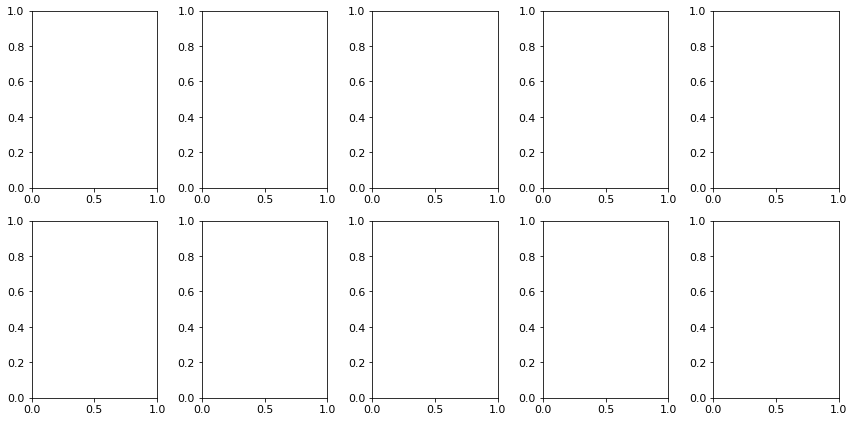

In [ ]:
plot_results('./runs/train/yolov5x_facemask/results.csv')

Copy validation images to `inference` folder

In [ ]:
!find ../facemask/images/val/ -maxdepth 1 -type f | head -50 | xargs cp -t "./data/images/"

We'll use the `detect.py` script to run our model on the images. Here are the parameters we're using:

- weights weights/best_yolov5x_clothing.pt - checkpoint of the model
- img 640 - resize the images to 640x640 px
- conf 0.2 - take into account predictions with confidence of 0.4 or higher
- source ./inference/images/ - path to the images

In [ ]:
!python detect.py --weights runs/train/yolov5x_facemask/weights/best.pt \
  --img 640 --conf 0.2 --source ./data/images/

In [ ]:
!python detect.py --weights runs/train/yolov5x_facemask/weights/best.pt \
  --img 640 --conf 0.2 --source 1

Save the model to file

In [ ]:
%cp runs/train/yolov5x_facemask/weights/best.pt /content/drive/My\ Drive

# Material

Implementation of different architectures in Pytorch
- [R-CNN model in Pytorch - Github](https://github.com/jwyang/faster-rcnn.pytorch)
- [YoloV4 model in Pytorch- Github](https://github.com/Tianxiaomo/pytorch-YOLOv4/blob/master/models.py)
- [Pre-trained model in Pytorch - Pytorch official page](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)
- [Data Augmentation, Optimization and ResNets in Pytoch - Jovian Notebooks](https://jovian.ai/aakashns/05b-cifar10-resnet)

Tutorial
- [Object Detection on Custom Dataset with YOLO (v5) Pytorch - Youtube](https://www.youtube.com/watch?v=XNRzZkZ-Byg)
- [R-CNN tutorial - ankur6ue's blog](https://www.telesens.co/2018/03/11/object-detection-and-classification-using-r-cnns#Implementation_Details_Training)
- [EfficientNetV2 and CoAtNet - Google Blog](https://ai.googleblog.com/2021/09/toward-fast-and-accurate-neural.html?ref=refind)
- [A Gentle Introduction to Object Recognition With Deep Learning - ML web](https://machinelearningmastery.com/object-recognition-with-deep-learning/)
- [Get Shit done with Pytorch - Book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)
- [YoLO v4 on Webcam - Colab Notebook](https://colab.research.google.com/drive/1xdjyBiY75MAVRSjgmiqI7pbRLn58VrbE?usp=sharing#scrollTo=RPDr23YFW_7c)

Previous work
- https://colab.research.google.com/drive/1kR52KS008KfFNY7dDs7MXRyTBnDuhOPN#scrollTo=kRnIZitiNyyA

- https://github.com/bluewarrior-soda/Algorithm-Bootcamp-Scholarship/blob/main/Personal%20Projects/Deep%20Learning%20Final%20Project/notebooks/%231%20-%20Data%20Extraction.ipynb

Data source
- https://www.kaggle.com/andrewmvd/face-mask-detection


Tensorflow
- [Tensorflow beginner tutorial by freecodecamp]( https://www.freecodecamp.org/learn/machine-learning-with-python/tensorflow/neural-networks-creating-a-model)

